In [1]:
from __future__ import print_function
from keras.applications import VGG16
from vis.utils import utils
from keras import activations

# Load the VGG16 network with ImageNet weights and original classificator
model = VGG16(weights='imagenet', include_top=True)

# Swap softmax activation with linear in the prediction layer and rebuilt the model.
# Necessary to run gradient optimization over class output visualizations.
# The warning 'the model was *not* compiled' can be ignored, we dont train here.
layer_idx = utils.find_layer_idx(model, 'predictions')
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

model.summary()

from vis.visualization import visualize_activation
from vis.input_modifiers import Jitter

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# Callback for a nice progress bar (standard messages of keras-vis are quite ugly)
from vis.callbacks import Print
import sys
class myprint(Print):
    def __init__(self, maxiter): 
        self.barLength = 40
        self.maxiter = maxiter
    def callback(self, i, named_losses, overall_loss, grads, wrt_value):
        progress = float(i) / float(self.maxiter)
        block = int(round(self.barLength*progress))
        msg = "Iteration {0} Loss {1:2.4f} ".format(i, overall_loss)
        text = "\r{0}: [{1}] {2:.2%}      ".format(msg, "="*(block-1) + ">" + "-"*(self.barLength-block), progress)
        sys.stdout.write(text)
        sys.stdout.flush()    
    def on_end(self):
        sys.stdout.write("\n")
        sys.stdout.flush()


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/usr/local/lib/python2.7/dist-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
# Generate a filter response visualization
layer_name = 'block4_conv2'  # Layer name to pick a filter from
filter_number = 35           # Number of the filter to generate a visualization
maxiterations = 50           # Increase for more pronounced picture

layer_idx = utils.find_layer_idx(model, layer_name)
img = visualize_activation(model, layer_idx, filter_indices=filter_number, max_iter=maxiterations, 
                           input_modifiers=[Jitter(0.05)], callbacks=[myprint(maxiterations)])
plt.imshow(img)
plt.show()

In [ ]:
# In case that filter response does not converge, (happens especially in block4/5 filters)
# a two-pass approach might give results.
#
# First pass: Generate a preliminary image without regularization weights
# Second pass: Feed this image as initial seed into the regular optimizer

layer_name = 'block5_conv3'
filter_number = 490
maxiterations = [50, 200] # Iterations for pass 1 / pass 2

layer_idx = utils.find_layer_idx(model, layer_name)
img = visualize_activation(model, layer_idx, filter_indices=filter_number, 
                           max_iter=maxiterations[0], tv_weight=0., 
                           input_modifiers=[Jitter(0.05)], callbacks=[myprint(maxiterations[0])])
img = visualize_activation(model, layer_idx, filter_indices=filter_number, 
                           max_iter=maxiterations[1], seed_input=img, 
                           input_modifiers=[Jitter(0.05)], callbacks=[myprint(maxiterations[1])])
plt.imshow(img)
plt.show()

In [ ]:
# Generate a class output visualization.
class_number = 980  # Class number to generate a visualization (see 'Imagenet_Classes.dat') (980 = Volcano)
maxiterations = 100  # Increase for more pronounced picture

layer_idx = utils.find_layer_idx(model, 'predictions')
img = visualize_activation(model, layer_idx, filter_indices=class_number, max_iter=maxiterations, 
                           input_modifiers=[Jitter(16)], callbacks=[myprint(maxiterations)])
plt.imshow(img)
plt.show()

Iteration 49 Loss -114.1338 : [======================================>-] 98.00%      
Iteration 199 Loss -13.9047 : [=======================================>] 99.50%      


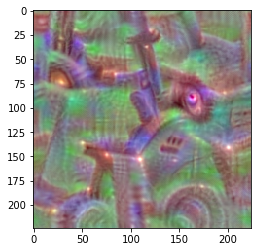

In [7]:
class_number = 561  # Class number to generate a visualization (see 'Imagenet_Classes.dat') (980 = Volcano)
maxiterations = [50, 200] # Iterations for pass 1 / pass 2

layer_idx = utils.find_layer_idx(model, 'predictions')
img = visualize_activation(model, layer_idx, filter_indices=class_number, 
                           max_iter=maxiterations[0], tv_weight=0., 
                           input_modifiers=[Jitter(0.05)], callbacks=[myprint(maxiterations[0])])
img = visualize_activation(model, layer_idx, filter_indices=class_number, 
                           max_iter=maxiterations[1], seed_input=img, 
                           input_modifiers=[Jitter(16)], callbacks=[myprint(maxiterations[1])])
plt.imshow(img)
plt.show()